# Clustering Algorithms

## k-means Clustering

Given $n$ points and $k$ as the number of clusters;
* Initialize $k$ points as centroids randomly $(\mu_1, \mu_2 \dots \mu_k)$.
* For each point $x_i$ assign it to the nearest cluster based on;
  $$
  c_i = \arg \min_{k^\prime} d(x_i, \mu_{k^\prime}), \quad k^\prime \in \{1,2, \dots k\}
  $$
* Update the cluster centroids based on the new point assignments.
  $$
  \mu_{k^\prime} = \arg \min_{z} \sum_{x_i \in C_{k^\prime}} d(x_i, z)
  $$
* Repeat these 2 steps until convergence, i.e. until centroids stop changing.

Commonly squared distance is used as the distance metric (and indeed name changes to k-medians or k-medoids when another metric is used but I will not be strict and call all of them k-means). In that case the update step turns into taking arithmetic average of the points in all dimensions. Below case shows different types of clusterable data that are adequate for different distance metrics.



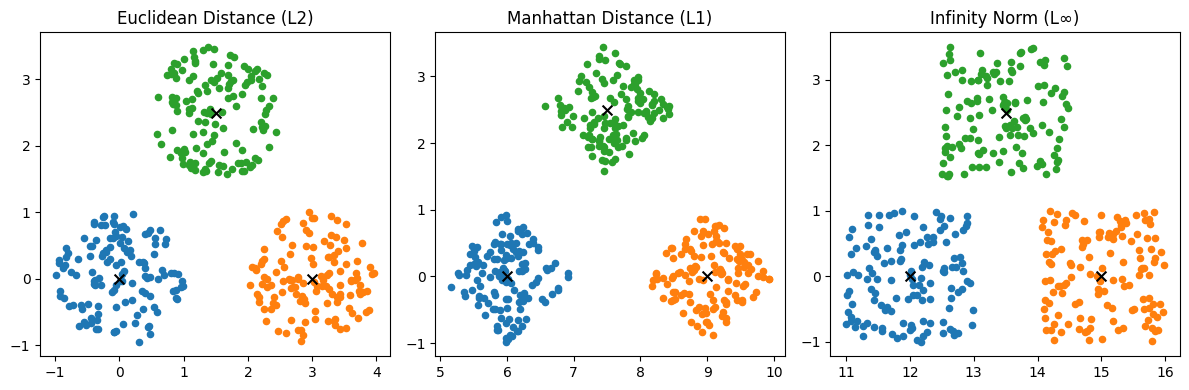

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def sample_points_within_norm(center, n_points, norm_type):
    """
    Generate n_points within a norm ball of radius 1 around a given center.
    """

    def distance(x, y, distance_norm='l2'):
        if distance_norm=='l2':
            return np.sqrt(x**2+y**2)
        elif distance_norm=='l1':
            return np.abs(x)+np.abs(y)
        elif distance_norm=='linf':
            return max(np.abs(x),np.abs(y))

    points = []
    while len(points) < n_points:
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if distance(x, y, distance_norm=norm_type) < 1:
            points.append([x, y])
    return np.array(points) + center

# Set cluster centers (well-separated)
centers = {'l2': [np.array([0, 0]), np.array([3, 0]), np.array([1.5, 2.5])],
           'l1': [np.array([6, 0]), np.array([9, 0]), np.array([7.5, 2.5])],
           'linf': [np.array([12, 0]), np.array([15, 0]), np.array([13.5, 2.5])]}

# Plotting setup
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
norm_labels = ['l2', 'l1', 'linf']
titles = ['Euclidean Distance (L2)', 'Manhattan Distance (L1)', 'Infinity Norm (L∞)']

for ax, norm_type, title in zip(axes, norm_labels, titles):
    for center in centers[norm_type]:
        points = sample_points_within_norm(center, 130, norm_type)
        ax.scatter(points[:, 0], points[:, 1], s=20)
        ax.scatter(*center, color='black', marker='x', s=50)  # Mark centroid
    ax.set_title(title)

plt.tight_layout()
plt.show()

3 common types of distance metrics are demonstrated in above diagram; which are $L_2$, $L_1$ and $L_∞$ norms. Each cluster in each distance case is drawn such that they have distance less than 1 from the center within the assoicated metric. This gives circular clusters for $L_2$, diamond shape clusters for $L_1$ and square shape clusters for $L_∞$ (this distance is maximum absolute value of the coordinates). In order to make proper clustering, the proper distance metric should be chosen. The difficulty in the task of choosing correct metric is that real data is high dimensional and it is not always possible to draw it on a diagram as in 2D case here. Thus, in those cases different methods must be addressed to find the correct metric. This can be using prior knowledge, making empirical conclusions or examining data in lower dimensions.

### kmeans++

One drawback of the above algorithm when applied with complete random initialization is that it is prone to converging to local optima rather than global one. One way to overcome this is running multiple initializations and pick the one with smallest total distance. However, this is computationally expensive. A smarter way is using a better initialization. This is why a variant of k-means called k-means++ is the standard way of applying it most of the time. It is the same algorithm with a modified initialization part as;

* Initialize the first centroid randomly among one of the data points $x_i$.
* For the points that no centroid are assigned, calculate the distance $d(x_i,\mu_{k^\prime})$ between the point and nearest centroid to it.
* For the new centroid, pick it based on a probability model that it is likely to be chosen if distance is larger. This will increase the likelihood that the centroids will be farther apart from each other.
* Repeat these 2 steps, until all $k$ centroids are initialized.

This seems like a longer algorithm for initialization and it increases the overhead at the beginning of the algorithm. However, since it increases the chances of faster convergence and also makes it more likely that convergence will be to global optimum, the overall algorithm time will be much shorter. Since there is also some randomness in this version as well, it will still not guarantee global convergence but chances are much higher and it will be increased with multiple initializations too. Though the number of different initializations can be much lower than the standard k-means.

### Implementation

Below is a from scratch implementation of the k-means algorithm where initialization is default to k-means++ and the distance metric as the squared distance but other options are available. It also allows for manual centroid initialization particularly for testing the effect of bad initialization to the result.

In [124]:
import numpy as np

def compute_distance(x, y, metric='euclidean'):
    if metric == 'euclidean':
        return np.sum((x - y) ** 2, axis=1)
    elif metric == 'manhattan':
        return np.sum(np.abs(x - y), axis=1)
    else:
        raise ValueError(f"Unsupported distance metric: {metric}")

def initialize_centroids(X, K, method='kmeans++', metric='euclidean', seed=None):
    n_samples, _ = X.shape
    centroids = []

    np.random.seed(seed)
    if method == 'random':
        indices = np.random.choice(n_samples, K, replace=False)
        centroids = X[indices]
    elif method == 'kmeans++':
        # First centroid randomly
        centroids.append(X[np.random.choice(n_samples)])
        for _ in range(1, K):
            dists = np.array([
                np.min([compute_distance(x.reshape(1, -1), c.reshape(1, -1), metric=metric)[0] for c in centroids]) for x in X])
            probs = dists / np.sum(dists)
            chosen_idx = np.random.choice(n_samples, p=probs)
            centroids.append(X[chosen_idx])
        centroids = np.array(centroids)
    else:
        raise ValueError(f"Unsupported initialization method: {method}")

    return centroids

def kmeans(X, K, max_iters=100, tol=1e-4, distance='euclidean', init='kmeans++', init_centroids=None, seed=None, verbose=False):
    X = np.array(X)
    n_samples, n_features = X.shape

    if init_centroids is not None:
        centroids = np.array(init_centroids)
        if centroids.shape != (K, n_features):
            raise ValueError("Initial centroids shape mismatch.")
    else:
        centroids = initialize_centroids(X, K, method=init, metric=distance, seed=seed)

    for iteration in range(max_iters):
        # Assignment step
        labels = np.zeros(n_samples, dtype=int)
        for i, x in enumerate(X):
            dists = np.array([compute_distance(x.reshape(1, -1), c.reshape(1, -1), metric=distance)[0] for c in centroids])
            labels[i] = np.argmin(dists)

        # Update step
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            cluster_points = X[labels == k]
            if len(cluster_points) == 0:
                new_centroids[k] = centroids[k]  # avoid collapse
            elif distance == 'euclidean':
                new_centroids[k] = np.mean(cluster_points, axis=0)
            elif distance == 'manhattan':
                new_centroids[k] = np.median(cluster_points, axis=0)
            else:
                raise ValueError(f"Unsupported update for distance: {distance}")

        # Check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if verbose:
            print(f"Iteration {iteration}, centroid shift: {shift:.6f}")
        if shift < tol:
            break
        centroids = new_centroids

    return centroids, labels


### Drawbacks of k-means

k-means is a powerful algorithm giving good performance for the proper cases with a simple and natural method. It can also be seen as the backbone of the many of the other clustering algorithms, all can be considered as minor or major modifications to k-means in some way. However, one major issue is that the number of clusters $k$ is an input to the algorithm that should be selected by the user and there is no established universal way of setting it. There are certain methods to help in decision process of $k$, a well-known one is the **elbow method** which is based on drawing the sum of distances with increasing number of $k$ and visually decide where the breakpoint is. Note that the important point is not finding the number $k$ minimizing the total distance which monotonically decreases with increasing $k$ and becomes 0 when $k=n$ (basically every point is its own cluster), but in a way decreased to a useful point that similar points are grouped together while different groups are separated.

There are also limitations to k-means due to its way of grouping based on distance and by the nature of data points, this will not be optimal. The examples for that will be given below to deepen the insights for the limitations. Still this does not make k-means any useless. It is still the basic comparison algorithm to make any clustering and in cases where strict separation is not mandatory, it will still give useful results (e.g. movie recommendations, which does not rely on a deterministic metric, even a suboptimal result can be good enough).

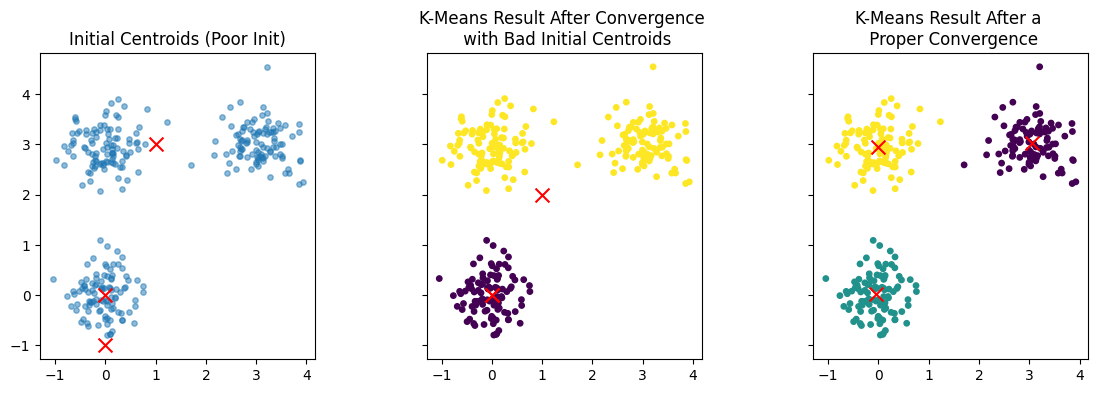

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

def generate_bad_init_example(seed=42):
    X, y = make_blobs(n_samples=300, centers=[[0, 0], [3, 3], [0, 3]], cluster_std=0.4, random_state=seed)
    # bad_init = np.array([[0, 0], [0.5, 0.5], [1, 1]])  # poor initial centroids
    bad_init = np.array([[0, 0], [0, -1], [1, 3]])  # poor initial centroids
    return X, bad_init

# Generate data and initial centroids
X2, init_centroids = generate_bad_init_example()

# Run kmeans with poor initialization
centroids, labels = kmeans(X2, K=3, max_iters=100, tol=1e-4, distance='euclidean', init_centroids=init_centroids, verbose=False)


# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# Initialization only
axes[0].scatter(X2[:, 0], X2[:, 1], s=15, alpha=0.5)
axes[0].scatter(init_centroids[:, 0], init_centroids[:, 1], c='red', marker='x', s=100)
axes[0].set_title("Initial Centroids (Poor Initialization)")
axes[0].set_aspect('equal', adjustable='box')

# Final clustering with bad initial centroids
axes[1].scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', s=15)
axes[1].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
axes[1].set_title("K-Means Result After Convergence \n with Bad Initial Centroids")
axes[1].set_aspect('equal', adjustable='box')


# Optimal convergence
centroids, labels = kmeans(X2, K=3, max_iters=100, tol=1e-4, distance='euclidean', seed=0, verbose=False)
axes[2].scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', s=15)
axes[2].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
axes[2].set_title("K-Means Result After a \n Proper Convergence")
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

**Bad Initialization**

In the example above we have 3 clusters that are easily separable in normal cases. However, as mentioned before k-means is prone to converging to local optima, as well. In order to artificially create this situation, centroids were given manually. This was done in a fashion, as shown in the 1st plot, such that 1 centroid is put approximately to the middle of two clusters and 2 of them both at the vicinity of the cluster that is at lower left. We can see that the centroid that was put between the 2 clusters ended up somewhere between them again merging the 2 clusters into 1 group. The other 2 centroids that started close to each other ended up on the same place which is also commonly observed in k-means if it locally minimizes the cost function. This fact can also be utilized in certain cases where the optimal $k$ is not known. Using a higher $k$ value if it is not substantially large may not be as harmful and even if they divide 1 cluster into groups, these can be merged manually after k-means, as well.

Note that although this example shows that bad initialization can end up suboptimal convergence, this is not as likely. Until finding the proper initial centroid values here, I have to make a few trials to make this demonstration but many of the trials ended up with optimal convergence case. It is just important to know that this is possible even if not likely, and one must be careful. Moreover, using kmeans++ will most probably avoid this to happen.

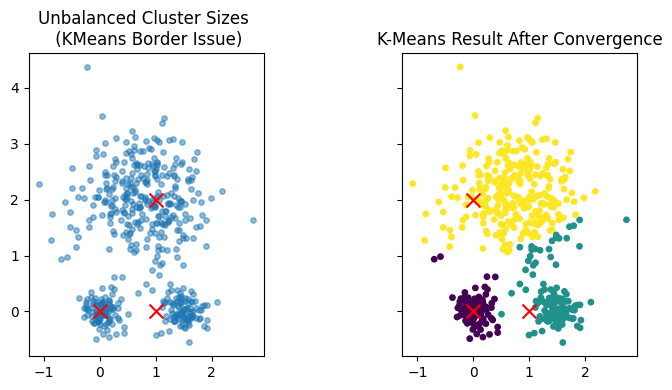

In [62]:
def generate_unbalanced_clusters(seed=1):
    np.random.seed(seed)
    cluster1 = np.random.normal(loc=[0, 0], scale=0.2, size=(100, 2))
    cluster2 = np.random.normal(loc=[1.5, 0], scale=0.2, size=(100, 2))
    cluster3 = np.random.normal(loc=[0.75, 2.0], scale=0.6, size=(300, 2))  # larger and wider
    return np.vstack([cluster1, cluster2, cluster3])

X3 = generate_unbalanced_clusters()

init_centroids=np.array([[0,0],[1,0],[1,2]])
centroids, labels = kmeans(X3, K=3, max_iters=100, tol=1e-4, distance='euclidean', init_centroids=init_centroids, verbose=False)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Initialization only
axes[0].scatter(X3[:, 0], X3[:, 1], s=15, alpha=0.5)
axes[0].scatter(init_centroids[:, 0], init_centroids[:, 1], c='red', marker='x', s=100)
axes[0].set_title("Unbalanced Cluster Sizes \n (KMeans Border Issue)")
axes[0].set_aspect('equal', adjustable='box')

# Final clustering
axes[1].scatter(X3[:, 0], X3[:, 1], c=labels, cmap='viridis', s=15)
axes[1].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
axes[1].set_title("K-Means Result After Convergence")
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

**Clusters with Varying Sizes**

In the above example we have 3 clusters again, where the bottom ones have similar small sizes and they are much smaller than the cluster on top of them. In this case, the k-means can find a case that is nearly optimal so most of the points can be assigned to proper clusters but still there are points on the border that are assigned to other clusters. Making the cluster grouping based only on the distance can have this effect inevitably so either further processing based on neighboring should be done after clustering or some sort of automatic size normalization should be applied. The DBSCAN algorithm which will be explained later in this notebook is also a good method to overcome this because it does the clustering directly based on proximity of points instead of distance to a semi-fixed centroid.

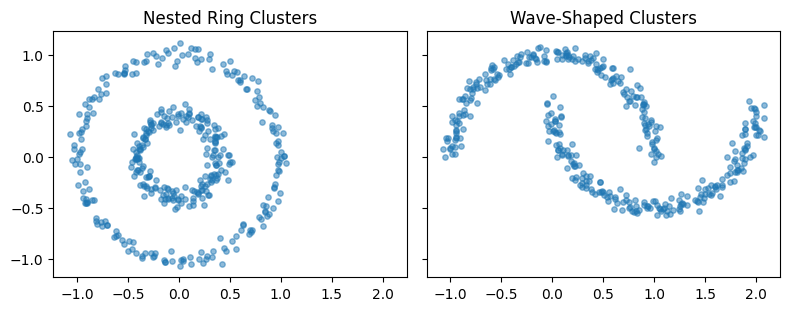

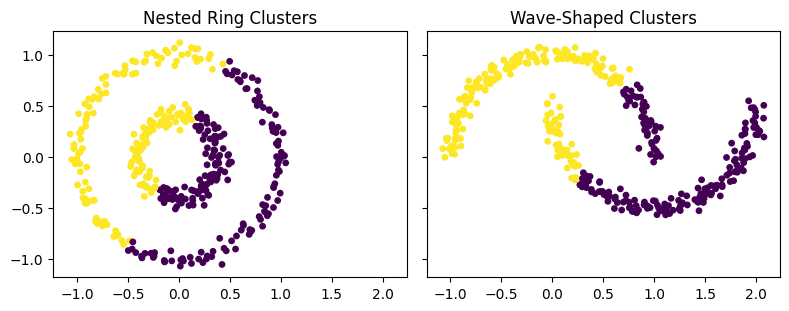

In [128]:
from sklearn.datasets import make_moons

def generate_nested_rings():
    X, _ = make_circles(n_samples=400, factor=0.4, noise=0.05)
    return X

def generate_wave_clusters():
    X, y = make_moons(n_samples=400, noise=0.05)
    return X, y

X4 = generate_nested_rings()
X5, _ = generate_wave_clusters()


# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Initialization of nested rings
axes[0].scatter(X4[:, 0], X4[:, 1], s=15, alpha=0.5)
axes[0].set_title("Nested Ring Clusters")
axes[0].set_aspect('equal', adjustable='box')

# Initialization of wave-like clusters
axes[1].scatter(X5[:, 0], X5[:, 1], s=15, alpha=0.5)
axes[1].set_title("Wave-Shaped Clusters")
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Convergence of nested rings
centroids, labels = kmeans(X4, K=2, max_iters=100, tol=1e-4, distance='euclidean', seed=0, verbose=False)
axes[0].scatter(X4[:, 0], X4[:, 1], c=labels, cmap='viridis', s=15)
axes[0].set_title("Nested Ring Clusters")
axes[0].set_aspect('equal', adjustable='box')

# Convergence of wave-like clusters
centroids, labels = kmeans(X5, K=2, max_iters=100, tol=1e-4, distance='euclidean', seed=0, verbose=False)
axes[1].scatter(X5[:, 0], X5[:, 1], c=labels, cmap='viridis', s=15)
axes[1].set_title("Wave-Shaped Clusters")
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

**Clusters with Non-circular Structures**

k-means is fundamentally designed for clusters that are grouped together and circular shaped but the data can be grouped in diffent ways based on their nature. 2 typical examples where k-means faile are given above where in one there are 2 rings within each other so impossible to group properly solely on distance and the other having a wave-like non-convex structure which again k-means is not designed for. These can be solved either first transforming data into a different space that will have distance-based grouping or using neighboring based clustering. The spectral clustering and DBSCAN that will be discussed in latter sections are remedies exactly for these cases.

## Spectral Clustering

This is an algorithm in order to cluster non-convex clusters more effectively. Since k-means is distance based, it fails in these cases ignoring relationships about connectivity and focuses only on proximity to a centroid. Spectral clustering can be thought to transform the original data to be clustered to another space where distance based approch of k-means can be sufficient to apply the clustering, because the last step is applying the clustering with a simple algorithm like k-means again. The novelty in spectral clustering is the method to make the transformation to the new space that this can be useful.

It can be summarized as;
* Calculate the Laplacian $L$ from the original data.
* Find the eigenvalues and eigenvectors of $L$ and take the $k$ eigenvectors with the largest eigenvalues. Create a new data matrix from these eigenvectors.
* Apply clustering on the data created from the eigenvectors. At this step, the k-means algorithm can be used.

It may be good to discuss at this point what Laplacian $L$ is which is the core of this algorithm. We need to constract a similarity (adjacency) matrix $S$ that should reflect the distances pairwise distances between point pairs first. There are different functions achieving this. One common example is the Gaussian kernel;

$$
S(x_1, x_2) = \exp \left( -\gamma \,\, \| x_1-x_2 \|^2\right)
$$

where $\gamma$ is a hyperparameter to be tuned. In order to obtain the unnormalized Laplacian $L$ this is subtracted from the diagonal matrix $D_{ii}=\sum_{j} S_{ij}$.

$$
L=D-S
$$

There is also the normalized form, which is also the default in the below implementation of the algorithm, where scale contribution of $D$ is removed by multiplying above unnormalized expression with $D^{-1/2}$ from left and right.

$$
L_{\text{nor}}=I-D^{-1/2} S D^{-1/2}
$$

Then, eigenvalue decomposition is applied on this matrix and only first $k$ eigenvectors are taken and this new data is put into another clustering algorithm which is commonly k-means again. At this point, one more point has to be added about the advantage of spectral clustering. Ideally in a case where there are perfectly separable $k$ clusters there will be only $k$ nonzero eigenvalues. In more realistic cases, there will generally be a sudden drop of eigenvalues which also gives us a heuristic to choose the optimal $k$ for the data which was harder in k-means.

In [63]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.linalg import eigh  # for symmetric matrices (Laplacian)


def spectral_clustering(X, n_clusters, gamma=15, normalized=True, verbose=False):
    # Step 1: Similarity Matrix using Gaussian kernel
    pairwise_sq_dists = cdist(X, X, metric='sqeuclidean')
    S = np.exp(-gamma * pairwise_sq_dists)

    # Step 2: Degree matrix
    D = np.diag(np.sum(S, axis=1))

    # Step 3: Laplacian
    if normalized:
        # Symmetric normalized Laplacian: L = I - D^{-1/2} S D^{-1/2}
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(S, axis=1)))
        L = np.eye(len(X)) - D_inv_sqrt @ S @ D_inv_sqrt
    else:
        L = D - S

    # Step 4: Eigen decomposition (use smallest k eigenvectors)
    eigvals, eigvecs = eigh(L)
    U = eigvecs[:, :n_clusters]  # Take first k eigenvectors

    # Optional: normalize rows (for normalized Laplacian)
    if normalized:
        U = U / np.linalg.norm(U, axis=1, keepdims=True)

    # Step 5: Run KMeans on rows of U
    centroids, labels = kmeans(U, K=n_clusters, distance='euclidean', init='kmeans++', verbose=verbose)

    return labels

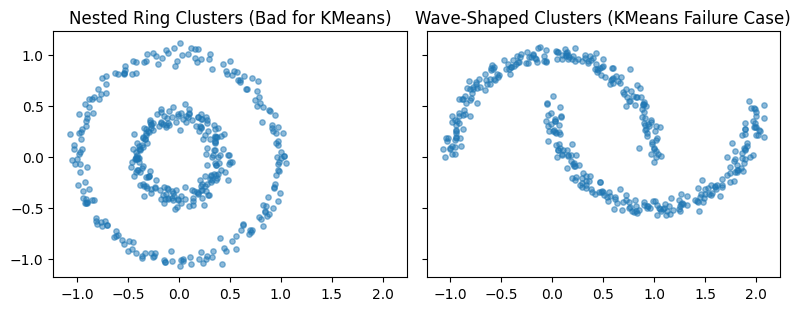

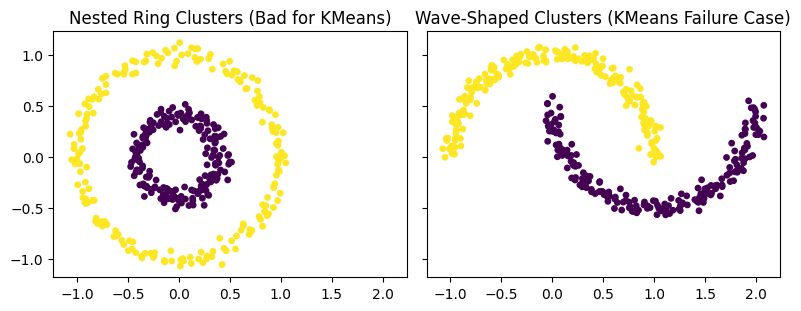

In [67]:
# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Initialization of nested rings
axes[0].scatter(X4[:, 0], X4[:, 1], s=15, alpha=0.5)
axes[0].set_title("Nested Ring Clusters")
axes[0].set_aspect('equal', adjustable='box')

# Initialization of wave-like clusters
axes[1].scatter(X5[:, 0], X5[:, 1], s=15, alpha=0.5)
axes[1].set_title("Wave-Shaped Clusters")
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Convergence of nested rings
labels = spectral_clustering(X4, n_clusters=2, gamma=15)
axes[0].scatter(X4[:, 0], X4[:, 1], c=labels, cmap='viridis', s=15)
axes[0].set_title("Nested Ring Clusters")
axes[0].set_aspect('equal', adjustable='box')

# Convergence of wave-like clusters
labels = spectral_clustering(X5, n_clusters=2, gamma=15)
axes[1].scatter(X5[:, 0], X5[:, 1], c=labels, cmap='viridis', s=15)
axes[1].set_title("Wave-Shaped Clusters")
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

Above example is the same example at the end of the k-means part where separations were suboptimal due to usage of distance. When spectral clustering is applied, the perfect separation can be done but with the expense of additional complexity.

## DBSCAN

**D**ensity-**b**ased **s**patial **c**lustering of **a**pplications with **n**oise (DBSCAN) is a connectivity based algorithm that unlike k-means looks for local distances and is superior when the cluster sizes differ or clusters having non-convex irregular shapes. It has 2 main parameters;
  * $ϵ$: The radius defining the neighbourhood or proximity.
  * $\text{min_pts}$: This is the minimum number of points within an $ϵ$ distance to consider a point **core point**.

As was defined above also there are different type of points in DBSCAN. These are;
  * **core points:** A point that has at least $\text{min_pts}$ number of points around it within $ϵ$ distance.
  * **border points:** A point that is within $ϵ$ distance of a core point but is not a core point itself (i.e. has less than $\text{min_pts}$ number of neighbours).
  * **outliers (noise points):** A point that is not within $ϵ$ distance of a core point.

Having a notion of noise or wrong points is a powerful side of DBSCAN where outlier points can effect the clustering performance and also the location of centroids in the k-means. Here there is a mechanism of rejecting those points if they are not close enough to some other neighbours.

A long algorithm description is not necessary here. Basically all the points are labelled as outlier at the beginning. Then, starting from a point if it has enough number of neighbours both the point and its neighbours are labelled as being in the same cluster and this process is repeated for the neighbours of neighbours, as well until all the points are visited.

In [154]:
import numpy as np
from scipy.spatial.distance import cdist

def dbscan(X, eps=0.5, min_samples=5):
    n = len(X)
    labels = -1*np.ones(n)  # -1 means unclassified/noise, initialize all points as noise/outlier
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0

    def find_neighbors(i):
        """Return indices of neighbors within eps of point i"""
        dists = np.linalg.norm(X - X[i], axis=1)
        return np.where(dists <= eps)[0]

    def expand_cluster(i, neighbors):

        # Here check the neighbours of the point-of-interest and in the meantime if other neighbours found add them to the search also.

        labels[i] = cluster_id

        j = 0
        while j < len(neighbors):
            curr_neigh = neighbors[j]

            if not visited[curr_neigh]:
                visited[curr_neigh] = True
                new_neighbors = find_neighbors(curr_neigh)

                if len(new_neighbors) >= min_samples:
                    new_neighbors = new_neighbors[~np.isin(new_neighbors, neighbors)]
                    neighbors = np.concatenate((neighbors, new_neighbors))

            labels[curr_neigh] = cluster_id

            j += 1

    for i in range(n):

        if visited[i]:
            continue

        visited[i] = True
        # Find the points that are within eps distance.
        neighbors = find_neighbors(i)
        if len(neighbors) >= min_samples:
            expand_cluster(i, neighbors)
            cluster_id += 1

    return labels


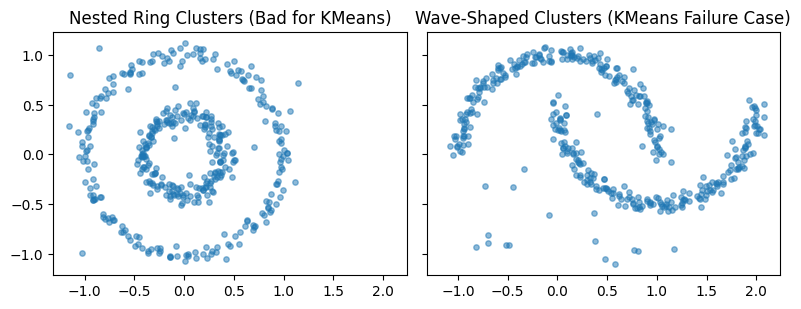

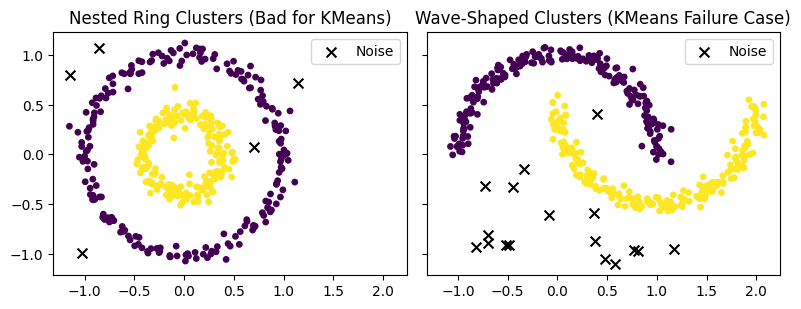

In [155]:
np.random.seed(0)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

X4_noisy = np.vstack([X4, np.random.uniform(low=-1.2, high=1.2, size=(20, 2))])
X5_noisy = np.vstack([X5, np.random.uniform(low=-1.2, high=1.2, size=(20, 2))])

# Left: Initialization only
axes[0].scatter(X4_noisy[:, 0], X4_noisy[:, 1], s=15, alpha=0.5)
axes[0].set_title("Nested Ring Clusters (Bad for KMeans)")
axes[0].set_aspect('equal', adjustable='box')

# Left: Initialization only
axes[1].scatter(X5_noisy[:, 0], X5_noisy[:, 1], s=15, alpha=0.5)
axes[1].set_title("Wave-Shaped Clusters (KMeans Failure Case)")
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Helper plot function
def plot_dbscan(ax, X, labels, title):
    is_noise = labels == -1
    ax.scatter(X[~is_noise][:, 0], X[~is_noise][:, 1], c=labels[~is_noise], cmap='viridis', s=15)
    ax.scatter(X[is_noise][:, 0], X[is_noise][:, 1], c='black', marker='x', s=50, label='Noise')
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper right')

# Left: Initialization only
labels = dbscan(X4_noisy, eps=0.2, min_samples=5)
plot_dbscan(axes[0], X4_noisy, labels, "Nested Ring Clusters (Bad for KMeans)")

# Left: Initialization only
labels = dbscan(X5_noisy, eps=0.2, min_samples=5)
plot_dbscan(axes[1], X5_noisy, labels, "Wave-Shaped Clusters (KMeans Failure Case)")

plt.tight_layout()
plt.show()

Here we have the same hard cases at the end of k-means again. The clustering can be done here because the algorithm searches for local neighboring relations. This gives the same performance for the spectral clustering case but the difference is the introduction of the noise points which did not exist in any of the previous 2 algorithms. This is a powerful addition becuase real data includes many points that may be useless so rejecting them can be better. It should also be added that in parametric cases like k-means where centroid centers are an output parameter and can be used for inference-like purposes, the presence of the noise also effects the parameters.

## Hierarchical Clustering

Hierarchical clustering is another clustering method that aims to assign similarity scores between individual or group of samples and clusters. Without having a cluster number $k$ beforehand, it looks for relationships between datapoints and based on these relationships, a tree-like structure called a dendogram is generated. Number of clusters can be decided based on this dendogram. Other methods do not allow for flexibility on cluster number as much as hierarchical approach, which theoretically allows for any value from $k=1$ (all points in one single cluster) to $k=n$ (each point is its own cluster) and gives a good measure for it based on a **linkage metric**. There are two main methods to construct the hierarchical tree;
  * **Agglomerative (bottom-up):** Each sample is assigned its own cluster (i.e. $k=n$) and then pairs of samples or group of samples are merged based on their similarity until they are gathered in 1 single cluster.
  * **Divisive (top-down) approach:** As the opposite of agglomerative approach, all samples are in the same cluster in the beginning and they are divided according to dissimilarity until each sample has its own cluster.

Hence, in both methods all the cluster numbers in $1\leq k \leq n$ are handled, the difference is that from which edge point they start the algorithm.

In [189]:
import numpy as np
import math
from collections import deque

def euclidean(a, b):
    return np.linalg.norm(a - b)

def hierarchical_clustering(X, mode='bottom-up', linkage='single'):

    def cluster_distance(c1, c2):
        if linkage == 'single':
            return min(euclidean(X[i], X[j]) for i in c1 for j in c2)
        elif linkage == 'complete':
            return max(euclidean(X[i], X[j]) for i in c1 for j in c2)
        elif linkage == 'average':
            return np.mean([euclidean(X[i], X[j]) for i in c1 for j in c2])
        else:
            raise ValueError("Unsupported linkage")

    n = len(X)
    merge_history = []  # [(cluster1_idx, cluster2_idx, distance, new_cluster_size)]

    if mode == 'bottom-up':
        cluster_ids = list(range(n))  # indices for tracking
        clusters = [{i} for i in range(n)]  # each point is a singleton cluster

        for _ in range(len(clusters)-1):

            # Find pairwise distances between clusters and save the minimum distance one to be merged.
            min_dist = math.inf
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = cluster_distance(clusters[i], clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        merge_idx = (i, j) if i>j else (j, i) # the ordering matters during deleting at the end

            # Merge 2 clusters
            new_cluster = clusters[merge_idx[0]] | clusters[merge_idx[1]]
            merge_history.append((cluster_ids[merge_idx[0]], cluster_ids[merge_idx[1]], min_dist, len(new_cluster)))

            # Update the overall clusters
            clusters.append(new_cluster)
            cluster_ids.append(n + len(merge_history) - 1)
            # Remove old clusters
            del clusters[merge_idx[0]], clusters[merge_idx[1]], \
                cluster_ids[merge_idx[0]], cluster_ids[merge_idx[1]]

    elif mode == 'top-down':
        cluster_ids = [n]  # start cluster IDs from n upward

        def recursive_split(indices):
            class ClusterNode:
                def __init__(self, indices, left = None, right = None,
                            distance = 0, id=None):
                    self.indices = indices
                    self.left = left
                    self.right = right
                    self.distance = distance
                    self.id = id

            if len(indices) == 1:
                return ClusterNode(indices, id=indices[0])

            # Find two farthest points
            max_dist = -1
            for idx_i, i in enumerate(indices):
                for j in indices[idx_i+1:]:
                    dist = euclidean(X[i], X[j])
                    if dist > max_dist:
                        split_idx = (i, j)
                        max_dist = dist

            # Assign points
            c1, c2 = [split_idx[0]], [split_idx[1]]
            for i in indices:
                if i in split_idx:
                    continue
                if euclidean(X[i], X[split_idx[0]]) < euclidean(X[i], X[split_idx[1]]):
                    c1.append(i)
                else:
                    c2.append(i)

            # Recursively split
            left_node, right_node = recursive_split(c1), recursive_split(c2)

            # Update merge history
            merge_history.append((left_node.id, right_node.id, max_dist, len(indices)))

            # Create current node
            node = ClusterNode(indices, left=left_node, right=right_node,
                               distance=max_dist, id=cluster_ids[0])
            cluster_ids[0] += 1

            return node

        recursive_split(list(range(n)))

    else:
        raise ValueError("mode must be 'bottom-up' or 'top-down'")

    return merge_history

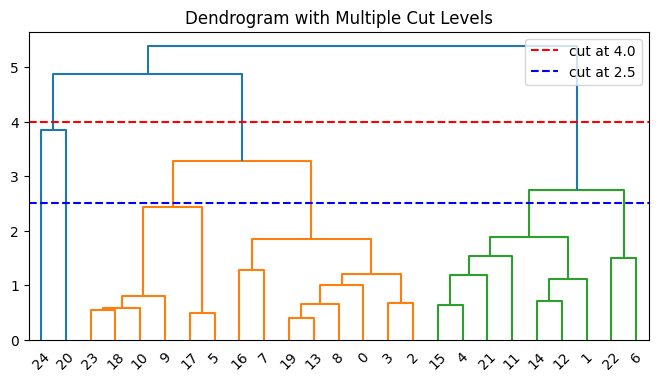

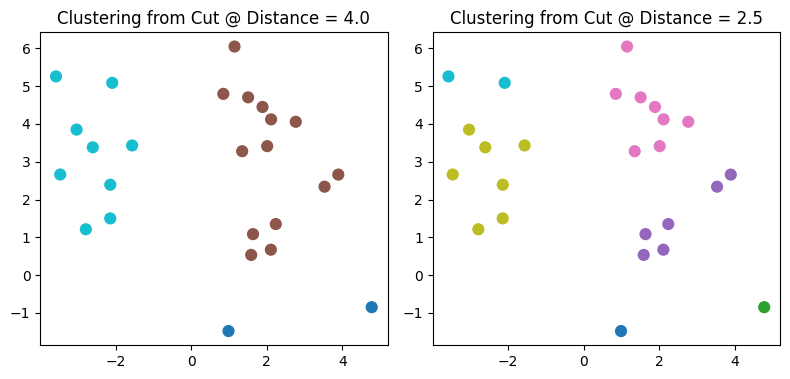

In [195]:
from scipy.cluster.hierarchy import fcluster, dendrogram
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate simple 2D data
X, _ = make_blobs(n_samples=25, centers=3, random_state=0, cluster_std=1.2)

# Run custom bottom-up clustering
merge_history = hierarchical_clustering(X, mode='bottom-up', linkage='average')

# Convert to SciPy linkage matrix
Z = np.zeros((len(merge_history), 4))
for i, (c1, c2, dist, size) in enumerate(merge_history):
    Z[i] = [c1, c2, dist, size]

# Plot dendrogram with cut lines
plt.figure(figsize=(8, 4))
dendrogram(Z, labels=np.arange(len(X)))
plt.axhline(y=4.0, color='red', linestyle='--', label='cut at 4.0')
plt.axhline(y=2.5, color='blue', linestyle='--', label='cut at 2.5')
plt.title("Dendrogram with Multiple Cut Levels")
plt.legend()
plt.show()

# Convert merge history to cluster labels
from scipy.cluster.hierarchy import fcluster

labels_level1 = fcluster(Z, t=4.0, criterion='distance')   # Higher cut → fewer clusters
labels_level2 = fcluster(Z, t=2.5, criterion='distance')   # Lower cut → more clusters

# Plot in 2D with both levels
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(X[:, 0], X[:, 1], c=labels_level1, cmap='tab10', s=60)
axes[0].set_title("Clustering from Cut @ Distance = 4.0")
axes[0].set_aspect('equal')

axes[1].scatter(X[:, 0], X[:, 1], c=labels_level2, cmap='tab10', s=60)
axes[1].set_title("Clustering from Cut @ Distance = 2.5")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()


## Gaussian Mixture Model (GMM)

Gaussian mixture model is a clustering technique that unlike the previous clustering algorithms discussed so far has a notion of *soft clusters* which means it assigns a probability of being in each cluster. This is provided by associating a probability distribution (which is Gaussian distribution for this case) to each cluster. If the distributions do not have a finite ending point and extend to $∞$, then this means there are no hard boudnaries for the cluster limits and each point has a nonzero probability of being in any of the clusters.

We model the data as a mixture of $K$ Gaussians:

$$
p(x) = \sum_{k=1}^K \pi_k \,\, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

with 3 parameters;
- $\pi_k$ are mixing coefficients ($\sum_k \pi_k = 1$), can be considered the weight of $k^\text{th}$ Gaussian density
- $\mu_k$ is the mean of component $k$
- $\Sigma_k$ is the covariance matrix of component $k$

The clustering algorithm is about finding the optimal values for the $\pi_k$,  $\mu_k$, $\Sigma_k$ parameters for each $k$. This is achieved by the expectation maximization (EM) algorithm which is consecutive application of expectation (E) and maximization (M) steps until convergence.



**Algorithm (EM for GMM):**

- **Input:** Data $X = \{x_1, \dots, x_n\}$, number of components $K$

- **Initialize:**
  - Means $\mu_k$ (e.g., randomly or using K-Means)
  - Covariances $\Sigma_k = I$ (identity matrices)
  - Mixing coefficients $\pi_k = \frac{1}{K}$

- **Repeat until convergence:**

  **E-step:** Compute responsibilities

  $$
  \gamma_{ik} = \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \, \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
  $$

  **M-step:** Update parameters

  $$
  N_k = \sum_{i=1}^n \gamma_{ik}, \quad
  \mu_k = \frac{1}{N_k} \sum_{i=1}^n \gamma_{ik} \, x_i, \quad
  \Sigma_k = \frac{1}{N_k} \sum_{i=1}^n \gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T, \quad
  \pi_k = \frac{N_k}{n}
  $$

- **Output:** Final parameters $\{\mu_k, \Sigma_k, \pi_k\}$ and soft assignments $\gamma_{ik}$


In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# ---------- Gaussian PDF ----------
def gaussian_pdf(x, mean, cov):
    norm_const = 1.0 / (np.power((2*np.pi), len(x)/2) * np.sqrt(np.linalg.det(cov)))
    result = np.exp(-0.5 * ((x - mean) @ np.linalg.inv(cov) @ (x - mean).T))
    return norm_const * result

# ---------- GMM using EM ----------
def GMM_EM(X, n_components, max_iter=100, tol=1e-4, verbose=False):
    n_samples, n_features = X.shape

    # Initialization of means, covariances and mixing weights
    means = X[np.random.choice(n_samples, n_components, replace=False)] # Random initialization
    covariances = np.array([np.eye(n_features) for _ in range(n_components)]) # Identity matrix initialization
    mix_weights = np.ones(n_components) / n_components # Uniform initialization

    log_likelihood_old = 0

    for iteration in range(max_iter):
        # E-step: compute responsibilities
        gamma = np.zeros((n_samples, n_components))
        for k in range(n_components):
            for i in range(n_samples):
                gamma[i, k] = mix_weights[k] * gaussian_pdf(X[i], means[k], covariances[k])
        gamma /= gamma.sum(axis=1, keepdims=True)

        # M-step: update parameters
        N_k = gamma.sum(axis=0)
        for k in range(n_components):
            means[k] = (1 / N_k[k]) * np.sum(gamma[:, k][:, np.newaxis] * X, axis=0)
            covariances[k] = (1 / N_k[k]) * (gamma[:, k][:, np.newaxis] * (X - means[k])).T @ (X - means[k])
            mix_weights[k] = N_k[k] / n_samples

        # Check log-likelihood
        log_likelihood = np.sum(np.log(np.sum([mix_weights[k] * np.array([gaussian_pdf(x, means[k], covariances[k]) for x in X]) for k in range(n_components)], axis=0)))

        if verbose:
            print(f"Iter {iteration}, log-likelihood: {log_likelihood:.4f}")

        if np.abs(log_likelihood - log_likelihood_old) < tol:
            break

        log_likelihood_old = log_likelihood

    labels = np.argmax(gamma, axis=1)
    return means, covariances, mix_weights, labels, gamma

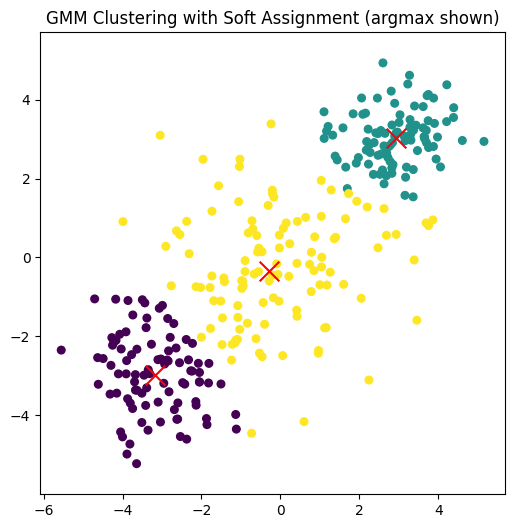

In [194]:
# ---------- Example ----------
# Create elliptical clusters
X, _ = make_blobs(n_samples=300, centers=[[-3, -3], [0, 0], [3, 3]],
                  cluster_std=[1.0, 1.5, 0.8], random_state=0)

# Apply GMM
means, covariances, mix_weights, labels, soft_labels = GMM_EM(X, n_components=3)

# ---------- Plot ----------
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.scatter(means[:, 0], means[:, 1], c='red', marker='x', s=200)
plt.title("GMM Clustering with Soft Assignment (argmax shown)")
plt.axis("equal")
plt.show()